In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import cv2

In [2]:
device = torch.device('cpu')

In [3]:
VGG_11 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11_bn', pretrained=True)
class VGG_CAM(nn.Module):
    def __init__(self, features = VGG_11.features, n_classes = 3):
        super(VGG_CAM, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, n_classes,bias=False)
            
    def forward(self, x):
        x = self.features(x)
        self.featuremap1 = x.detach()
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
preprocess = transforms.Compose([
    transforms.CenterCrop(1024),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

Using cache found in /home/cz2064/.cache/torch/hub/pytorch_vision_v0.6.0


In [4]:
model = VGG_CAM().to(device)
files = torch.load('../Python File/checkpoint_Model.pt', map_location='cpu')
model.load_state_dict(files['best_model_wts'])

/scratch/cz2064/envs/BDML_pip/lib/python3.6/site-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type VGG_CAM. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


<All keys matched successfully>

In [47]:
test_df_path = '/scratch/cz2064/myjupyter/BDML/Project/Phase5/Train_Test_Split/test.csv'
test_df = pd.read_csv(test_df_path)
test_df[100:]

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,type,label
100,1eae5db6-08e8-40db-8392-099626b4f2c8,TCGA-37-3783-01A-01-TS1.053386eb-d46d-4986-ad1...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-37-3783,TCGA-37-3783-01A,Primary Tumor,Tumor-LUSC,1
101,3a3d7005-2626-49d2-9565-d25250059283,TCGA-38-4630-11A-01-TS1.00ed18d6-acf8-4950-bb4...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-38-4630,TCGA-38-4630-11A,Solid Tissue Normal,Normal,0
102,643930ba-4821-4a92-a36e-c93dc7ef1723,TCGA-73-4668-11A-01-BS1.296b9b76-6ebb-47fa-9f5...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-73-4668,TCGA-73-4668-11A,Solid Tissue Normal,Normal,0
103,c7168931-a830-4251-9f58-3a4e3b3bea1a,TCGA-37-4132-01A-01-BS1.62dd6eab-b7c1-4fdf-9b4...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-37-4132,TCGA-37-4132-01A,Primary Tumor,Tumor-LUSC,1
104,9779142d-969f-4162-a909-fe8db28b9195,TCGA-97-7937-01A-01-TS1.52bec102-5ea6-4f89-b3c...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-97-7937,TCGA-97-7937-01A,Primary Tumor,Tumor-LUAD,2
...,...,...,...,...,...,...,...,...,...,...
411,dd76a429-9fc2-47db-8ebc-8d6dda0bc99d,TCGA-50-6590-11A-01-TS1.fefe9444-70ce-4911-a03...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-6590,TCGA-50-6590-11A,Solid Tissue Normal,Normal,0
412,18f7943d-6a38-4ebc-ab56-354b4980c96a,TCGA-37-4135-01A-01-TS1.fd901f17-fe66-4709-b28...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-37-4135,TCGA-37-4135-01A,Primary Tumor,Tumor-LUSC,1
413,05919b71-18da-47b5-b5fb-af3ff07a871a,TCGA-78-7163-11A-01-TS1.1ce6c71a-1466-48d2-89d...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-78-7163,TCGA-78-7163-11A,Solid Tissue Normal,Normal,0
414,08172153-d520-4d0d-9291-faebfbd4d92d,TCGA-56-8307-01A-01-TS1.7537de75-53be-4ace-aec...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-56-8307,TCGA-56-8307-01A,Primary Tumor,Tumor-LUSC,1


In [6]:
sample = test_df.loc[[5]]
sample

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,type,label
5,a8bb6445-bd9f-4644-b212-2c9d97844c96,TCGA-56-1622-11A-01-TS1.267fb2d0-ef06-402a-9df...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-56-1622,TCGA-56-1622-11A,Solid Tissue Normal,Normal,0


In [7]:
imgage_folder = '/scratch/cz2064/myjupyter/BDML/Project/Data/data_1024/'

In [50]:
# Normal sample
sample = test_df.loc[[102]]
file_id = sample['File ID'].values[0]
file_name = sample['File Name'].values[0]
image_path = imgage_folder + file_id + '/' + file_name[:-4] + '_1024.jpg'
normal_sample = Image.open(image_path)

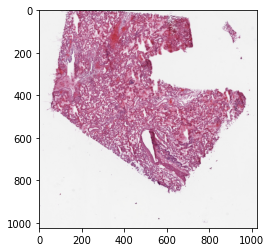

In [51]:
plt.imshow(normal_sample)

In [52]:
# LUSC sample
sample = test_df.loc[[100]]
file_id = sample['File ID'].values[0]
file_name = sample['File Name'].values[0]
image_path = imgage_folder + file_id + '/' + file_name[:-4] + '_1024.jpg'
LUSC_sample = Image.open(image_path)

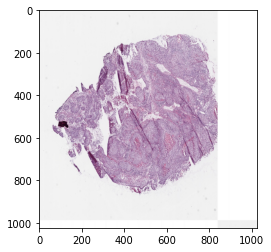

In [53]:
plt.imshow(LUSC_sample)

In [54]:
# LUAD sample
sample = test_df.loc[[104]]
file_id = sample['File ID'].values[0]
file_name = sample['File Name'].values[0]
image_path = imgage_folder + file_id + '/' + file_name[:-4] + '_1024.jpg'
LUAD_sample = Image.open(image_path)

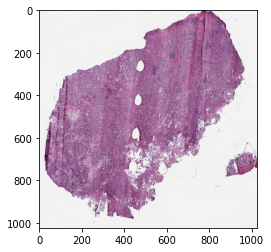

In [55]:
plt.imshow(LUAD_sample)

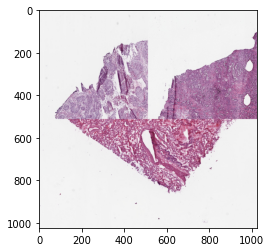

In [57]:
new_sample = Image.new('RGB', (1024, 1024))
new_sample.paste(normal_sample.crop((0, 512, 1024, 1024)), (0, 512, 1024, 1024))
new_sample.paste(LUSC_sample.crop((0, 0, 512, 512)), (0, 0, 512, 512))
new_sample.paste(LUAD_sample.crop((0, 0, 512, 512)), (512, 0, 1024, 512))
plt.imshow(new_sample)

In [58]:
new_sample.save("new_sample.jpg") 

In [59]:
model.eval()
original_image = cv2.imread("new_sample.jpg")
image_tensor = preprocess(new_sample).unsqueeze(0)
sample_input = image_tensor.to(device,dtype=torch.float)
output = model(sample_input)
pre_class = output.data.max(-1)[1].cpu().numpy()

In [60]:
Feature_map = model.featuremap1.cpu().numpy()
print('Feature map:',Feature_map.shape)

Feature map: (1, 512, 32, 32)


In [61]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-1].data.cpu().numpy())
print('Weights:',weight_softmax.shape)

Weights: (3, 512)


In [62]:
# Feature map 1
weights_map1 = weight_softmax[0]
cam_1 = weights_map1.dot(Feature_map.reshape((512,32*32)))
cam_1 = cam_1.reshape(32,32)
# Feature map 2
weights_map2 = weight_softmax[1]
cam_2 = weights_map2.dot(Feature_map.reshape((512,32*32)))
cam_2 = cam_2.reshape(32,32)
# Feature map 3
weights_map3 = weight_softmax[2]
cam_3 = weights_map3.dot(Feature_map.reshape((512,32*32)))
cam_3 = cam_3.reshape(32,32)

In [63]:
cam = cam_1
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
CAM = cv2.resize(cam_img, (1024,1024))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
cv2.imwrite('cam_1.jpg', heatmap*0.3+0.7*original_image)

True

In [64]:
cam = cam_2
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
CAM = cv2.resize(cam_img, (1024,1024))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
cv2.imwrite('cam_2.jpg', heatmap*0.3+0.7*original_image)

True

In [65]:
cam = cam_3
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
CAM = cv2.resize(cam_img, (1024,1024))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
cv2.imwrite('cam_3.jpg', heatmap*0.3+0.7*original_image)

True

In [66]:
pre_class

array([1])